Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


Constants

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANELS=3
EPOCHS=20

Data Preprocessing

In [4]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "mango_dataset",

    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    shuffle=True,
   
)
   

NameError: name 'tf' is not defined

In [ ]:
class_names= dataset.class_names
class_names

['Anthracnose',
 'Bacterial Canker',
 'Cutting Weevil',
 'Die Back',
 'Gall Midge',
 'Healthy',
 'Powdery Mildew',
 'Sooty Mould']

In [ ]:
len(dataset)

125

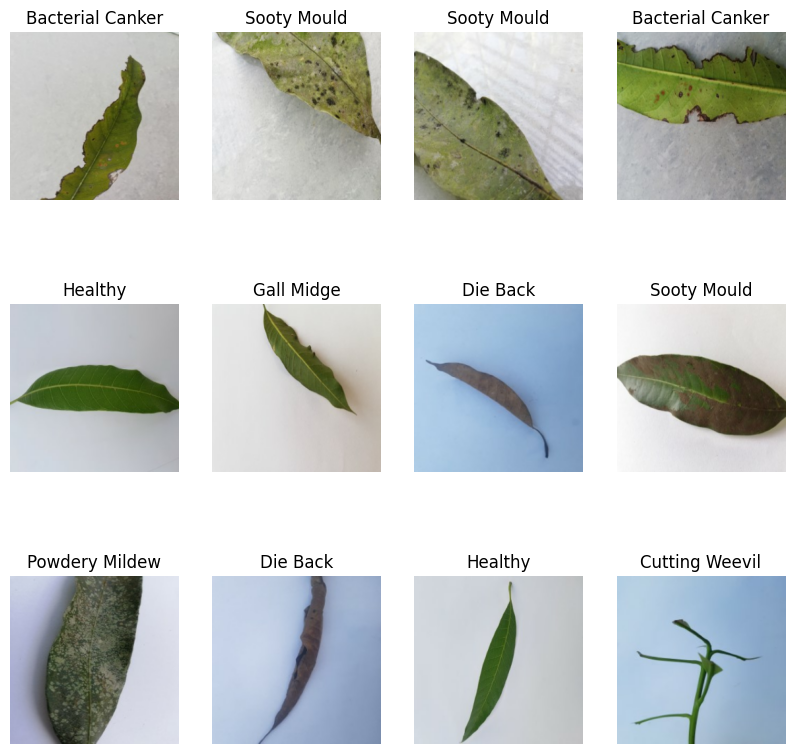

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [ ]:
len(dataset)

125

In [ ]:
# 80% ==> training 
# 20% ==> validaton,10% test

In [ ]:
train_size=0.8
len(dataset)*train_size

100.0

In [ ]:
train_ds=dataset.take(100)
len(train_ds)

100

In [ ]:
test_ds=dataset.skip(100)
len(test_ds)

25

In [ ]:
val_size=0.1
len(dataset)*val_size

12.5

In [ ]:
val_ds=test_ds.take(12)
len(val_ds)

12

function t split dataset into train,validation and test


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)


100

In [ ]:
len(val_ds)


12

In [ ]:

len(test_ds)

13

Catch shuffle and prefetch the datset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
 data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Building


In [ ]:


# Adjusting number of classes to 8
n_classes = 8

# Input shape for your images
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANELS)

# Defining the model
model = models.Sequential([
    resize_and_rescale,  # Ensure this is defined correctly for image preprocessing
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),  # Changed to 8 classes
])

# Build the model
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANELS))


In [ ]:


# # Adjusting number of classes to 8
# n_classes = 8

# # Example definitions: adjust these according to your dataset
# IMAGE_SIZE = 224  # for example, you might choose 224x224 for mango leaves
# CHANELS = 3
# BATCH_SIZE = 32

# # Preprocessing: resize images and rescale pixel values
# resize_and_rescale = tf.keras.Sequential([
#     layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#     layers.Rescaling(1./255)
# ])

# # Defining the improved model
# model = models.Sequential([
#     resize_and_rescale,  # Preprocessing layer

#     # Block 1: Convolution + BatchNorm + Pooling
#     layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),

#     # Block 2
#     layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),

#     # Block 3
#     layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),

#     # Block 4
#     layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),

#     # Instead of Flatten, use GlobalAveragePooling2D to reduce overfitting risk
#     layers.GlobalAveragePooling2D(),

#     # Fully Connected Layers with Dropout Regularization
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(n_classes, activation='softmax')  # Output layer for 8 classes
# ])

# # Build the model with an appropriate input shape
# model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANELS))
# model.summary()  # Optional: to see model details


In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR for stable training
#     loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  # Use CategoricalCrossentropy
#     metrics=[
#         'accuracy',  
#         tf.keras.metrics.Precision(name='precision'),  
#         tf.keras.metrics.Recall(name='recall')  
#     ]
# )


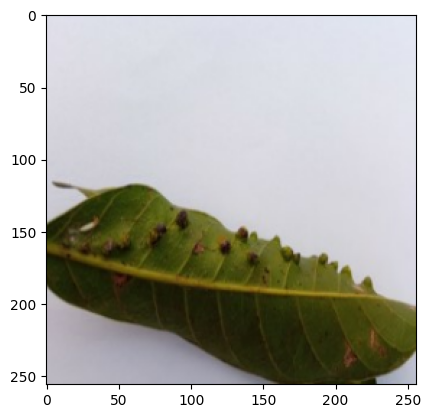

In [ ]:
for images_batch,labels_batch in test_ds.take(1):
    plt.imshow(images_batch[0].numpy().astype('uint8'))

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs= 20 ,
)

Epoch 1/50
100/100 [==============================] - 37s 372ms/step - loss: 0.1151 - accuracy: 0.9553 - val_loss: 0.1147 - val_accuracy: 0.9531
Epoch 2/50
100/100 [==============================] - 37s 372ms/step - loss: 0.0810 - accuracy: 0.9700 - val_loss: 0.1611 - val_accuracy: 0.9479
Epoch 3/50
100/100 [==============================] - 40s 395ms/step - loss: 0.1130 - accuracy: 0.9600 - val_loss: 0.2544 - val_accuracy: 0.9141
Epoch 4/50
100/100 [==============================] - 39s 390ms/step - loss: 0.0814 - accuracy: 0.9722 - val_loss: 0.1250 - val_accuracy: 0.9375
Epoch 5/50
100/100 [==============================] - 40s 395ms/step - loss: 0.0898 - accuracy: 0.9663 - val_loss: 0.1626 - val_accuracy: 0.9479
Epoch 6/50
100/100 [==============================] - 39s 385ms/step - loss: 0.0455 - accuracy: 0.9850 - val_loss: 0.1100 - val_accuracy: 0.9531
Epoch 7/50
100/100 [==============================] - 37s 371ms/step - loss: 0.0792 - accuracy: 0.9712 - val_loss: 0.1368 - val_ac

In [ ]:
scores=model.evaluate(test_ds)

NameError: name 'model' is not defined

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


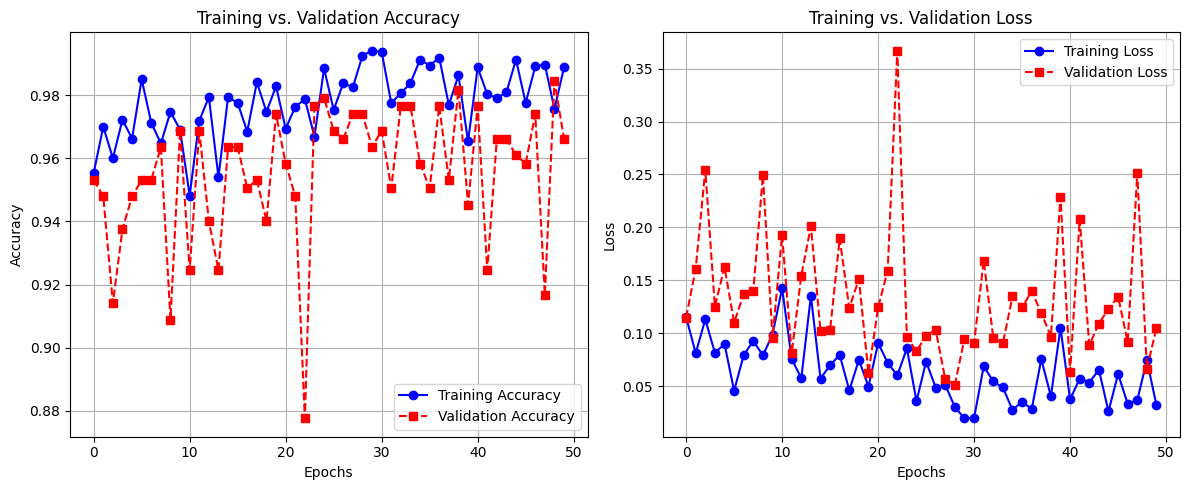

In [ ]:


# Ensure the number of epochs is dynamic
epochs = len(acc)

plt.figure(figsize=(12, 5))  # Increased figure size for better visibility

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, marker='o', linestyle='-', label='Training Accuracy', color='blue')
plt.plot(range(epochs), val_acc, marker='s', linestyle='--', label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)  # Add grid for better readability

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, marker='o', linestyle='-', label='Training Loss', color='blue')
plt.plot(range(epochs), val_loss, marker='s', linestyle='--', label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


first image to predict
actual label: Gall Midge
1/1 [==============================] - 0s 125ms/step
predicted label: Gall Midge


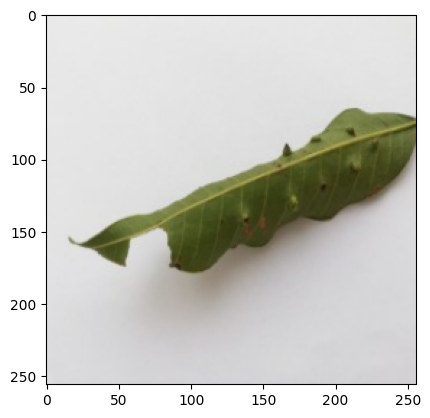

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

NameError: name 'plt' is not defined

In [ ]:
model_version=3
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets
